In [9]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm # Use notebook version for better display (used in predict_rewards)
from collections import deque # For observation history buffer
import glob # For finding checkpoints
from importnb import Notebook # For importing from other notebooks/scripts
import sys # For exiting gracefully
import cv2 # Needed for image decoding
import base64 # For decoding image from rpyc server
import io # For handling image bytes
import logging # For RemoteJetBot logging
import config
import models
from models import SimpleUNetV1, SimpleRewardEstimator
with Notebook():
    from action_conditioned_diffusion_world_model_gemini import linear_beta_schedule, cosine_beta_schedule, get_index_from_list
    from jetbot_remote_client import RemoteJetBot

logging.basicConfig(level=logging.INFO) # Set logging level (INFO, DEBUG, etc.)
logger = logging.getLogger('MPC_Client')


In [10]:
# --- JetBot Server Connection ---
JETBOT_SERVER_IP = "192.168.68.64" # <<< --- REPLACE WITH YOUR JETBOT'S ACTUAL IP ADDRESS
# Port identified from jetbot_server.py (uses rpyc)
JETBOT_SERVER_PORT = 18861

# --- Device Setup ---
device = torch.device(config.DEVICE if hasattr(config, 'DEVICE') else ("cuda" if torch.cuda.is_available() else "cpu"))
print(f"Using device: {device}")

# --- Model Paths ---
# World model path will be determined automatically by searching for 'model_best_epoch_*.pth'.
# Reward model path remains the same.
REWARD_MODEL_PATH = os.path.join(config.OUTPUT_DIR, 'reward_estimator', 'reward_estimator_best.pth')

# --- MPC Parameters ---
HORIZON = 5             # Planning horizon (number of steps to look ahead) H
N_ACTIONS = 1           # Dimensionality of the action space (RIGHT MOTOR ONLY)

# --- Discrete Actions ---
DISCRETE_ACTIONS = [0.0, 0.1] # The two possible actions

# --- Real Robot Parameters ---
REAL_ROBOT_FRAME_DELAY = 1.0 / 30.0 # Based on 30 FPS assumption
ACTION_SCALE = 1.0 # Keep for potential future use, but actions are discrete now

# --- Image Preprocessing (Matches config.TRANSFORM) ---
IMAGE_CHANNELS = 3 # Assuming 3 channels based on config.TRANSFORM and models
preprocess = transforms.Compose([
    # Note: Image received from get_frame is BGR numpy array.
    # Convert to RGB, then PIL, then transform.
    transforms.ToPILImage(), # Convert numpy array (RGB) to PIL Image
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalization from config.TRANSFORM
])
# Inverse transform for visualization
denormalize = transforms.Compose([
    transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1/0.5, 1/0.5, 1/0.5]),
    transforms.Normalize(mean=[-0.5, -0.5, -0.5], std=[1.0, 1.0, 1.0]),
])

# --- Diffusion Parameters (from config.py or defaults) ---
NUM_TIMESTEPS = getattr(config, 'NUM_TIMESTEPS', 10) # Use config value, default 10 based on log
BETA_START = getattr(config, 'BETA_START', 1e-4) #
BETA_END = getattr(config, 'BETA_END', 0.02) #
SCHEDULE_TYPE = getattr(config, 'SCHEDULE_TYPE', 'linear') #
NUM_PREV_FRAMES = config.NUM_PREV_FRAMES # Number of previous frames model expects

# --- Visualization Buffer ---
VISUALIZATION_BUFFER_SIZE = 50 # Store last N frames for visualization on exit

# %% [markdown]
# ## Diffusion Schedule Setup

# %%
# Calculate betas using imported functions
if SCHEDULE_TYPE == 'linear':
    betas = linear_beta_schedule(NUM_TIMESTEPS, BETA_START, BETA_END)
elif SCHEDULE_TYPE == 'cosine':
    betas = cosine_beta_schedule(NUM_TIMESTEPS)
else:
    raise ValueError(f"Unknown beta schedule: {SCHEDULE_TYPE}")

# Pre-calculate diffusion constants
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
# Ensure tensors are on the correct device
betas = betas.to(device)
alphas = alphas.to(device)
alphas_cumprod = alphas_cumprod.to(device)



Using device: cuda


In [11]:
# --- Load World Model (SimpleUNetV1) ---
# Simplified Automatic Checkpoint Loading: Assumes at least one 'best' model exists.
checkpoint_to_load = None
loaded_config_from_checkpoint = None
world_model = None

# 1. Find the latest 'best' checkpoint file
# Use config for checkpoint directory
best_checkpoints = glob.glob(os.path.join(config.CHECKPOINT_DIR, 'model_best_epoch_*.pth'))
# Sort by epoch number (descending) to get the latest best
best_checkpoints.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]), reverse=True)
checkpoint_to_load = best_checkpoints[0] # Assume the list is not empty and take the first one
print(f"Attempting to load latest best world model checkpoint: {checkpoint_to_load}")

# 2. Load checkpoint metadata and instantiate the correct model
try:
    # Load directly without checking os.path.exists, assuming glob found a valid file
    checkpoint = torch.load(checkpoint_to_load, map_location=device)

    # --- Get Architecture Info from Checkpoint ---
    model_arch_name = None
    num_prev_frames_loaded = config.NUM_PREV_FRAMES # Default to current config
    time_emb_dim_loaded = getattr(config, 'TIME_EMB_DIM', 32) # Default

    if 'config' in checkpoint and checkpoint['config'] is not None: # Check if config exists and is not None
         loaded_config_from_checkpoint = checkpoint['config']
         if 'model_architecture' in loaded_config_from_checkpoint:
             model_arch_name = loaded_config_from_checkpoint['model_architecture']
             print(f"Checkpoint indicates model architecture: {model_arch_name}")
         if 'num_prev_frames' in loaded_config_from_checkpoint:
             num_prev_frames_loaded = loaded_config_from_checkpoint['num_prev_frames']
         if 'time_emb_dim' in loaded_config_from_checkpoint: # Check if time_emb_dim is saved
             time_emb_dim_loaded = loaded_config_from_checkpoint['time_emb_dim']
    else:
         # Fallback if checkpoint lacks architecture info - use current config
         print("Warning: Checkpoint missing config info or config is None. Using current config values.")
         model_arch_name = config.MODEL_ARCHITECTURE # Get from current config

    # --- Instantiate the model ---
    if model_arch_name and hasattr(models, model_arch_name):
         model_class = getattr(models, model_arch_name)

         # Ensure NUM_PREV_FRAMES matches between loaded model and current config expectation
         if num_prev_frames_loaded != config.NUM_PREV_FRAMES:
             print(f"Warning: Mismatch in NUM_PREV_FRAMES between loaded model ({num_prev_frames_loaded}) and current config ({config.NUM_PREV_FRAMES}). Using value from loaded model: {num_prev_frames_loaded}")
             # Update NUM_PREV_FRAMES globally to match the loaded model
             NUM_PREV_FRAMES = num_prev_frames_loaded
         else:
             print(f"Using NUM_PREV_FRAMES = {NUM_PREV_FRAMES}")


         world_model = model_class(
             image_channels=IMAGE_CHANNELS,
             time_emb_dim=time_emb_dim_loaded, # Use loaded or default
             num_prev_frames=NUM_PREV_FRAMES # Use potentially updated value
         ).to(device)
         print(f"Instantiated world model: {model_arch_name}")

         # --- Load State Dict ---
         world_model.load_state_dict(checkpoint['model_state_dict'])
         world_model.eval() # Set to evaluation mode
         print(f"Successfully loaded world model state from epoch {checkpoint.get('epoch', 'N/A')}.")

    else:
         print(f"ERROR: Model class '{model_arch_name}' not found in models.py or could not be determined!")
         world_model = None # Ensure model is None if instantiation failed

except FileNotFoundError:
    # This error might still occur if the file path from glob is somehow invalid later
    print(f"Error: World model checkpoint file not found at path: {checkpoint_to_load}")
    world_model = None
except KeyError as e:
    print(f"Error loading world model checkpoint (KeyError: {e}). Checkpoint structure might be different.")
    world_model = None
except Exception as e:
     print(f"An unexpected error occurred loading world model checkpoint {checkpoint_to_load}: {e}.")
     world_model = None


# Ensure model is loaded before proceeding
if world_model is None:
    print("World model could not be loaded. Exiting.")
    sys.exit(1) # Exit script
else:
    print(f"Using World Model: {world_model.__class__.__name__}")

for param in world_model.parameters():
    param.requires_grad = False

Attempting to load latest best world model checkpoint: C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\test_output\checkpoints\model_best_epoch_70.pth
Checkpoint indicates model architecture: SimpleUNetV1
Using NUM_PREV_FRAMES = 4
Instantiated world model: SimpleUNetV1
Successfully loaded world model state from epoch 70.
Using World Model: SimpleUNetV1


In [12]:
# --- Load Reward Model (SimpleRewardEstimator) ---
reward_model = SimpleRewardEstimator(
    input_channels=IMAGE_CHANNELS,
    image_size=config.IMAGE_SIZE # From config.py
).to(device)

print(f"Attempting to load reward model from: {REWARD_MODEL_PATH}")
try:
    if not os.path.exists(REWARD_MODEL_PATH):
         print(f"Error: Reward model checkpoint file not found: {REWARD_MODEL_PATH}")
         raise FileNotFoundError(f"Checkpoint not found: {REWARD_MODEL_PATH}")

    reward_model.load_state_dict(torch.load(REWARD_MODEL_PATH, map_location=device))
    reward_model.eval()
    print(f"Reward model (SimpleRewardEstimator) loaded successfully from {REWARD_MODEL_PATH}")
except FileNotFoundError:
    raise
except Exception as e:
    print(f"An unexpected error occurred loading reward model: {e}")
    raise

for param in reward_model.parameters():
    param.requires_grad = False

Attempting to load reward model from: C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\test_output\reward_estimator\reward_estimator_best.pth
Reward model (SimpleRewardEstimator) loaded successfully from C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\test_output\reward_estimator\reward_estimator_best.pth


In [13]:
remote_robot = None # Initialize variable
try:
    # Use the imported RemoteJetBot class
    remote_robot = RemoteJetBot(JETBOT_SERVER_IP)
    # Connection happens in __init__
    time.sleep(1.0) # Give connection time to stabilize
except Exception as e:
     logger.error(f"Failed to initialize RemoteJetBot: {e}")
     sys.exit(1)


INFO:JetBotClient:Connecting to JetBot at 192.168.68.64:18861
INFO:JetBotClient:Connected successfully!


Image(value=b'', format='jpeg', height='300', width='400')

In [14]:
def get_observation_real():
    """Captures an image via RPyC and preprocesses it."""
    if remote_robot is None or remote_robot.conn is None or remote_robot.conn.closed:
        logger.error("RPyC connection not available for get_observation_real.")
        return None

    try:
        # Use the get_frame method from the imported class
        image_bgr = remote_robot.get_frame() # Returns BGR numpy array or None

        if image_bgr is None or image_bgr.size == 0:
             logger.warning("Received invalid/empty image frame from remote robot.")
             return None

        # Convert BGR numpy array to RGB for preprocessing
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

        # Preprocess (includes ToPILImage, Resize, ToTensor, Normalize)
        obs_tensor = preprocess(image_rgb).to(device)
        return obs_tensor

    except Exception as e:
        logger.error(f"Error during get_observation_real: {e}")
        return None


def apply_action_real(right_motor_action):
    """Sends the action to the JetBot via RPyC."""
    if remote_robot is None or remote_robot.conn is None or remote_robot.conn.closed:
        logger.error("RPyC connection not available for apply_action_real.")
        return

    try:
        right_motor_speed = float(right_motor_action) * ACTION_SCALE
        left_motor_speed = 0.0 # Keep left motor off

        # Clamping (optional, server might also clamp)
        right_motor_speed = max(min(right_motor_speed, 1.0), -1.0)

        # Use the set_motors method from the imported class
        success = remote_robot.set_motors(left_motor_speed, right_motor_speed)
        # Optional: Check success flag if needed

        # Wait for the frame delay *after* sending the command
        time.sleep(REAL_ROBOT_FRAME_DELAY)

    except Exception as e:
        logger.error(f"Error during RPyC apply_action_real: {e}")



In [15]:
def format_prev_frames(obs_buffer):
    """ Concatenates previous frames from buffer for model input. """
    # Use the globally determined NUM_PREV_FRAMES
    if len(obs_buffer) < NUM_PREV_FRAMES:
         # This should ideally not happen after initialization
         print(f"Error: Observation buffer has {len(obs_buffer)} frames, needs {NUM_PREV_FRAMES} for prev_frames.")
         return None # Indicate error

    # Get the NUM_PREV_FRAMES most recent observations *excluding the latest one*
    prev_frames_list = list(obs_buffer)[-(NUM_PREV_FRAMES + 1):-1]
    # Concatenate along the channel dimension (C) -> (C*num_prev, H, W)
    prev_frames_tensor = torch.cat(prev_frames_list, dim=0)
    return prev_frames_tensor


def predict_rewards(world_model, reward_model, initial_obs_buffer_list, action_sequences_batch):
    """
    Predicts the cumulative reward for a batch of action sequences using the
    diffusion world model and reward model. Uses real previous frames history.

    Args:
        world_model: The SimpleUNetV1 model.
        reward_model: The SimpleRewardEstimator model.
        initial_obs_buffer_list (list): List of initial observation tensors,
                                        size NUM_PREV_FRAMES + 1.
        action_sequences_batch (torch.Tensor): Batch of action sequences (B, H, N_ACTIONS=1).

    Returns:
        torch.Tensor: Predicted cumulative rewards for each sequence (B,).
    """
    batch_size, horizon, num_actions = action_sequences_batch.shape
    total_rewards = torch.zeros(batch_size, device=device)

    # Ensure models are in evaluation mode
    world_model.eval()
    reward_model.eval()

    # --- Initialize hypothetical observation buffers for each sample in the batch ---
    hypothetical_buffers = [deque(initial_obs_buffer_list, maxlen=NUM_PREV_FRAMES + 1) for _ in range(batch_size)]

    with torch.no_grad():
        for h_step in range(horizon):
            actions_t = action_sequences_batch[:, h_step, :] # Actions for this horizon step (B, 1)

            # --- Prepare inputs for the batch ---
            batch_prev_frames_list = []
            for i in range(batch_size):
                # Use the globally determined NUM_PREV_FRAMES here
                prev_frames = format_prev_frames(hypothetical_buffers[i])
                if prev_frames is None:
                    print(f"Error: Could not format prev_frames for batch sample {i} at horizon {h_step}")
                    return torch.full((batch_size,), -float('inf'), device=device) # Return very low reward on error
                batch_prev_frames_list.append(prev_frames)

            batch_prev_frames_tensor = torch.stack(batch_prev_frames_list, dim=0)

            # --- Predict next observation using DDPM sampling loop for the batch ---
            x = torch.randn((batch_size, IMAGE_CHANNELS, config.IMAGE_SIZE, config.IMAGE_SIZE), device=device)

            # Inner loop for diffusion steps
            for i in reversed(range(0, NUM_TIMESTEPS)):
                t_val = i
                t = torch.full((batch_size,), t_val, device=device, dtype=torch.long)

                # Use imported get_index_from_list
                alpha_t = get_index_from_list(alphas, t, x.shape)
                alpha_hat_t = get_index_from_list(alphas_cumprod, t, x.shape)
                beta_t = get_index_from_list(betas, t, x.shape)

                predicted_noise = world_model(x=x, timestep=t, action=actions_t, prev_frames=batch_prev_frames_tensor)

                term1 = 1 / torch.sqrt(alpha_t)
                term2 = (1 - alpha_t) / torch.sqrt(1 - alpha_hat_t)
                x = term1 * (x - term2 * predicted_noise)

                if t_val > 0:
                    noise = torch.randn_like(x)
                    variance = torch.sqrt(beta_t)
                    x = x + variance * noise

            predicted_obs_batch = torch.clamp(x, -1.0, 1.0)

            # --- Predict reward ---
            rewards_t = reward_model(predicted_obs_batch).squeeze(-1)

            if torch.isnan(rewards_t).any() or torch.isinf(rewards_t).any():
                print(f"Warning: NaN/Inf detected in predicted rewards at horizon step {h_step}. Replacing with 0.")
                rewards_t = torch.nan_to_num(rewards_t, nan=0.0, posinf=0.0, neginf=0.0)

            total_rewards += rewards_t

            # --- Update hypothetical buffers ---
            for i in range(batch_size):
                 hypothetical_buffers[i].append(predicted_obs_batch[i])

    return total_rewards


def choose_best_action(world_model, reward_model, current_obs_buffer_list):
    """
    Chooses the best discrete action (0.0 or 0.1) by predicting rewards
    for constant action sequences over the horizon.

    Args:
        world_model: The SimpleUNetV1 model.
        reward_model: The SimpleRewardEstimator model.
        current_obs_buffer_list (list): The current observation buffer list
                                       (size NUM_PREV_FRAMES + 1).

    Returns:
        float: The best discrete action (0.0 or 0.1).
        tuple: Predicted rewards for (action 0.0, action 0.1)
    """
    # Use the globally determined NUM_PREV_FRAMES
    if len(current_obs_buffer_list) != NUM_PREV_FRAMES + 1:
        print(f"Error: Action selection requires a full observation buffer ({NUM_PREV_FRAMES + 1} frames). Got {len(current_obs_buffer_list)}.")
        return DISCRETE_ACTIONS[0], (-float('inf'), -float('inf')) # Return default stop action and invalid rewards

    # --- Create the two constant action sequences ---
    action_seq_0 = torch.full((1, HORIZON, N_ACTIONS), DISCRETE_ACTIONS[0], device=device, dtype=torch.float32)
    action_seq_1 = torch.full((1, HORIZON, N_ACTIONS), DISCRETE_ACTIONS[1], device=device, dtype=torch.float32)

    # --- Predict rewards for both sequences ---
    # Calling predict_rewards twice
    reward_0 = predict_rewards(world_model, reward_model, current_obs_buffer_list, action_seq_0)
    reward_1 = predict_rewards(world_model, reward_model, current_obs_buffer_list, action_seq_1)

    # --- Compare rewards and choose action ---
    reward_0_val = reward_0.item() if torch.isfinite(reward_0).all() else -float('inf')
    reward_1_val = reward_1.item() if torch.isfinite(reward_1).all() else -float('inf')

    # **ADDED PRINT STATEMENT**
    print(f"  Predicted Rewards -> Action {DISCRETE_ACTIONS[0]}: {reward_0_val:.4f} | Action {DISCRETE_ACTIONS[1]}: {reward_1_val:.4f}")

    if reward_1_val > reward_0_val:
        best_action = DISCRETE_ACTIONS[1] # Action 0.1
    else:
        # Default to 0.0 if rewards are equal or 0.1 is not better
        best_action = DISCRETE_ACTIONS[0] # Action 0.0

    # **ADDED PRINT STATEMENT**
    print(f"  ==> Chosen Action: {best_action}")
    return best_action, (reward_0_val, reward_1_val) # Return chosen action and predicted rewards


Starting Continuous MPC Control Loop...
Collected initial observation 1/5
Collected initial observation 2/5
Collected initial observation 3/5
Collected initial observation 4/5
Collected initial observation 5/5
Initial observation buffer filled. Starting continuous control.

--- Step 1 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 10.0974 | Action 0.1: 9.9787
  ==> Chosen Action: 0.0
Planning finished in 1.064s
Applying action: 0.0
Step 1 Summary | Plan Time: 1.064s | Step Time: 1.229s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (10.097, 9.979)

--- Step 2 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 14.0371 | Action 0.1: 13.7355
  ==> Chosen Action: 0.0
Planning finished in 0.752s
Applying action: 0.0
Step 2 Summary | Plan Time: 0.752s | Step Time: 0.928s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (14.037, 13.735)

--- Step 3 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 18.3221 | Action 0.1: 18.2435
  ==> Chosen Action: 0.0
Planning finished in 0.750s
Applying action: 0.0
Step 3 Summary | Plan Time: 0.750s | Step Time: 0.917s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (18.322, 18.244)

--- Step 4 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 16.5940 | Action 0.1: 15.6063
  ==> Chosen Action: 0.0
Planning finished in 0.749s
Applying action: 0.0
Step 4 Summary | Plan Time: 0.749s | Step Time: 0.923s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (16.594, 15.606)

--- Step 5 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.8804 | Action 0.1: 13.5886
  ==> Chosen Action: 0.0
Planning finished in 0.752s
Applying action: 0.0
Step 5 Summary | Plan Time: 0.752s | Step Time: 0.920s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (13.880, 13.589)

--- Step 6 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.4417 | Action 0.1: 12.0002
  ==> Chosen Action: 0.0
Planning finished in 0.746s
Applying action: 0.0
Step 6 Summary | Plan Time: 0.746s | Step Time: 0.918s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (13.442, 12.000)

--- Step 7 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.8957 | Action 0.1: 12.0682
  ==> Chosen Action: 0.0
Planning finished in 0.747s
Applying action: 0.0
Step 7 Summary | Plan Time: 0.747s | Step Time: 0.976s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (12.896, 12.068)

--- Step 8 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.9093 | Action 0.1: 11.7703
  ==> Chosen Action: 0.0
Planning finished in 0.745s
Applying action: 0.0
Step 8 Summary | Plan Time: 0.745s | Step Time: 0.869s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (12.909, 11.770)

--- Step 9 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.7438 | Action 0.1: 12.3948
  ==> Chosen Action: 0.0
Planning finished in 0.744s
Applying action: 0.0
Step 9 Summary | Plan Time: 0.744s | Step Time: 0.919s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (12.744, 12.395)

--- Step 10 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.8365 | Action 0.1: 12.3265
  ==> Chosen Action: 0.0
Planning finished in 0.743s
Applying action: 0.0
Step 10 Summary | Plan Time: 0.743s | Step Time: 0.927s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (12.836, 12.326)

--- Step 11 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.9015 | Action 0.1: 12.5630
  ==> Chosen Action: 0.0
Planning finished in 0.742s
Applying action: 0.0
Step 11 Summary | Plan Time: 0.742s | Step Time: 0.921s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (12.901, 12.563)

--- Step 12 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.3667 | Action 0.1: 12.4075
  ==> Chosen Action: 0.0
Planning finished in 0.748s
Applying action: 0.0
Step 12 Summary | Plan Time: 0.748s | Step Time: 0.920s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (13.367, 12.408)

--- Step 13 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.0686 | Action 0.1: 12.3110
  ==> Chosen Action: 0.1
Planning finished in 0.741s
Applying action: 0.1
Step 13 Summary | Plan Time: 0.741s | Step Time: 0.937s | Chosen Action: R=0.1 | Pred Rewards (0.0, 0.1): (12.069, 12.311)

--- Step 14 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 11.9382 | Action 0.1: 12.1787
  ==> Chosen Action: 0.1
Planning finished in 0.745s
Applying action: 0.1
Step 14 Summary | Plan Time: 0.745s | Step Time: 0.902s | Chosen Action: R=0.1 | Pred Rewards (0.0, 0.1): (11.938, 12.179)

--- Step 15 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.5940 | Action 0.1: 11.6791
  ==> Chosen Action: 0.0
Planning finished in 0.744s
Applying action: 0.0
Step 15 Summary | Plan Time: 0.744s | Step Time: 0.884s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (12.594, 11.679)

--- Step 16 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.1405 | Action 0.1: 12.8782
  ==> Chosen Action: 0.0
Planning finished in 0.745s
Applying action: 0.0
Step 16 Summary | Plan Time: 0.745s | Step Time: 0.862s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (13.140, 12.878)

--- Step 17 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 14.4416 | Action 0.1: 13.8036
  ==> Chosen Action: 0.0
Planning finished in 0.747s
Applying action: 0.0
Step 17 Summary | Plan Time: 0.747s | Step Time: 0.938s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (14.442, 13.804)

--- Step 18 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 14.1362 | Action 0.1: 13.9296
  ==> Chosen Action: 0.0
Planning finished in 0.746s
Applying action: 0.0
Step 18 Summary | Plan Time: 0.746s | Step Time: 0.907s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (14.136, 13.930)

--- Step 19 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 14.3283 | Action 0.1: 13.7299
  ==> Chosen Action: 0.0
Planning finished in 0.745s
Applying action: 0.0
Step 19 Summary | Plan Time: 0.745s | Step Time: 0.925s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (14.328, 13.730)

--- Step 20 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.8612 | Action 0.1: 13.1331
  ==> Chosen Action: 0.0
Planning finished in 0.745s
Applying action: 0.0
Step 20 Summary | Plan Time: 0.745s | Step Time: 0.916s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (13.861, 13.133)

--- Step 21 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.7263 | Action 0.1: 13.1308
  ==> Chosen Action: 0.0
Planning finished in 0.743s
Applying action: 0.0
Step 21 Summary | Plan Time: 0.743s | Step Time: 0.921s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (13.726, 13.131)

--- Step 22 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.5562 | Action 0.1: 13.4905
  ==> Chosen Action: 0.0
Planning finished in 0.744s
Applying action: 0.0
Step 22 Summary | Plan Time: 0.744s | Step Time: 0.925s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (13.556, 13.491)

--- Step 23 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.3048 | Action 0.1: 13.2432
  ==> Chosen Action: 0.0
Planning finished in 0.744s
Applying action: 0.0
Step 23 Summary | Plan Time: 0.744s | Step Time: 0.915s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (13.305, 13.243)

--- Step 24 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 14.1110 | Action 0.1: 12.7436
  ==> Chosen Action: 0.0
Planning finished in 0.746s
Applying action: 0.0
Step 24 Summary | Plan Time: 0.746s | Step Time: 0.826s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (14.111, 12.744)

--- Step 25 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.5802 | Action 0.1: 13.0508
  ==> Chosen Action: 0.0
Planning finished in 0.744s
Applying action: 0.0
Step 25 Summary | Plan Time: 0.744s | Step Time: 0.918s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (13.580, 13.051)

--- Step 26 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.7385 | Action 0.1: 12.8563
  ==> Chosen Action: 0.0
Planning finished in 0.747s
Applying action: 0.0
Step 26 Summary | Plan Time: 0.747s | Step Time: 0.927s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (13.738, 12.856)

--- Step 27 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 14.1590 | Action 0.1: 13.5506
  ==> Chosen Action: 0.0
Planning finished in 0.747s
Applying action: 0.0
Step 27 Summary | Plan Time: 0.747s | Step Time: 0.946s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (14.159, 13.551)

--- Step 28 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 14.3792 | Action 0.1: 13.4685
  ==> Chosen Action: 0.0
Planning finished in 0.747s
Applying action: 0.0
Step 28 Summary | Plan Time: 0.747s | Step Time: 0.895s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (14.379, 13.469)

--- Step 29 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.8898 | Action 0.1: 12.7425
  ==> Chosen Action: 0.0
Planning finished in 0.751s
Applying action: 0.0
Step 29 Summary | Plan Time: 0.751s | Step Time: 0.919s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (13.890, 12.743)

--- Step 30 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1


  Predicted Rewards -> Action 0.0: 13.6623 | Action 0.1: 13.8948
  ==> Chosen Action: 0.1
Planning finished in 0.749s
Applying action: 0.1


DEBUG:JetBotClient:Command sent successfully


Step 30 Summary | Plan Time: 0.749s | Step Time: 0.980s | Chosen Action: R=0.1 | Pred Rewards (0.0, 0.1): (13.662, 13.895)

--- Step 31 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 14.0223 | Action 0.1: 13.4688
  ==> Chosen Action: 0.0
Planning finished in 0.753s
Applying action: 0.0
Step 31 Summary | Plan Time: 0.753s | Step Time: 0.927s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (14.022, 13.469)

--- Step 32 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 14.2246 | Action 0.1: 13.9026
  ==> Chosen Action: 0.0
Planning finished in 0.748s
Applying action: 0.0
Step 32 Summary | Plan Time: 0.748s | Step Time: 0.862s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (14.225, 13.903)

--- Step 33 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 14.3496 | Action 0.1: 13.0247
  ==> Chosen Action: 0.0
Planning finished in 0.744s
Applying action: 0.0
Step 33 Summary | Plan Time: 0.744s | Step Time: 0.971s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (14.350, 13.025)

--- Step 34 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.6849 | Action 0.1: 12.5234
  ==> Chosen Action: 0.0
Planning finished in 0.745s
Applying action: 0.0
Step 34 Summary | Plan Time: 0.745s | Step Time: 0.872s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (13.685, 12.523)

--- Step 35 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.3849 | Action 0.1: 11.9482
  ==> Chosen Action: 0.0
Planning finished in 0.747s
Applying action: 0.0
Step 35 Summary | Plan Time: 0.747s | Step Time: 0.925s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (13.385, 11.948)

--- Step 36 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.3307 | Action 0.1: 12.2822
  ==> Chosen Action: 0.0
Planning finished in 0.746s
Applying action: 0.0
Step 36 Summary | Plan Time: 0.746s | Step Time: 0.920s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (13.331, 12.282)

--- Step 37 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.6169 | Action 0.1: 11.7718
  ==> Chosen Action: 0.0
Planning finished in 0.747s
Applying action: 0.0
Step 37 Summary | Plan Time: 0.747s | Step Time: 0.918s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (12.617, 11.772)

--- Step 38 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.0733 | Action 0.1: 12.4283
  ==> Chosen Action: 0.0
Planning finished in 0.750s
Applying action: 0.0
Step 38 Summary | Plan Time: 0.750s | Step Time: 0.925s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (13.073, 12.428)

--- Step 39 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.9229 | Action 0.1: 11.6325
  ==> Chosen Action: 0.0
Planning finished in 0.749s
Applying action: 0.0
Step 39 Summary | Plan Time: 0.749s | Step Time: 0.921s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (12.923, 11.633)

--- Step 40 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.4943 | Action 0.1: 11.9700
  ==> Chosen Action: 0.0
Planning finished in 0.755s
Applying action: 0.0
Step 40 Summary | Plan Time: 0.755s | Step Time: 0.922s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (12.494, 11.970)

--- Step 41 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.2089 | Action 0.1: 12.4802
  ==> Chosen Action: 0.0
Planning finished in 0.751s
Applying action: 0.0
Step 41 Summary | Plan Time: 0.751s | Step Time: 0.926s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (13.209, 12.480)

--- Step 42 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.7058 | Action 0.1: 12.2433
  ==> Chosen Action: 0.0
Planning finished in 0.746s
Applying action: 0.0
Step 42 Summary | Plan Time: 0.746s | Step Time: 1.078s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (12.706, 12.243)

--- Step 43 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.0937 | Action 0.1: 12.3335
  ==> Chosen Action: 0.0
Planning finished in 0.745s
Applying action: 0.0
Step 43 Summary | Plan Time: 0.745s | Step Time: 0.860s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (13.094, 12.333)

--- Step 44 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.1425 | Action 0.1: 12.1868
  ==> Chosen Action: 0.0
Planning finished in 0.746s
Applying action: 0.0
Step 44 Summary | Plan Time: 0.746s | Step Time: 0.823s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (13.142, 12.187)

--- Step 45 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.1010 | Action 0.1: 12.1659
  ==> Chosen Action: 0.0
Planning finished in 0.746s
Applying action: 0.0
Step 45 Summary | Plan Time: 0.746s | Step Time: 0.920s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (13.101, 12.166)

--- Step 46 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.5153 | Action 0.1: 12.0282
  ==> Chosen Action: 0.0
Planning finished in 0.748s
Applying action: 0.0
Step 46 Summary | Plan Time: 0.748s | Step Time: 0.925s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (12.515, 12.028)

--- Step 47 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.9906 | Action 0.1: 12.6919
  ==> Chosen Action: 0.0
Planning finished in 0.747s
Applying action: 0.0
Step 47 Summary | Plan Time: 0.747s | Step Time: 0.918s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (12.991, 12.692)

--- Step 48 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.9039 | Action 0.1: 12.1070
  ==> Chosen Action: 0.0
Planning finished in 0.752s
Applying action: 0.0
Step 48 Summary | Plan Time: 0.752s | Step Time: 0.924s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (12.904, 12.107)

--- Step 49 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.0180 | Action 0.1: 12.1205
  ==> Chosen Action: 0.0
Planning finished in 0.750s
Applying action: 0.0
Step 49 Summary | Plan Time: 0.750s | Step Time: 0.931s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (13.018, 12.121)

--- Step 50 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.1274 | Action 0.1: 12.3037
  ==> Chosen Action: 0.0
Planning finished in 0.749s
Applying action: 0.0
Step 50 Summary | Plan Time: 0.749s | Step Time: 0.913s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (13.127, 12.304)

--- Step 51 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.7171 | Action 0.1: 12.1959
  ==> Chosen Action: 0.0
Planning finished in 0.752s
Applying action: 0.0
Step 51 Summary | Plan Time: 0.752s | Step Time: 0.922s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (12.717, 12.196)

--- Step 52 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.1607 | Action 0.1: 12.7186
  ==> Chosen Action: 0.0
Planning finished in 0.749s
Applying action: 0.0
Step 52 Summary | Plan Time: 0.749s | Step Time: 0.924s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (13.161, 12.719)

--- Step 53 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.2638 | Action 0.1: 12.0359
  ==> Chosen Action: 0.0
Planning finished in 0.751s
Applying action: 0.0
Step 53 Summary | Plan Time: 0.751s | Step Time: 0.922s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (13.264, 12.036)

--- Step 54 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.0929 | Action 0.1: 12.1075
  ==> Chosen Action: 0.0
Planning finished in 0.751s
Applying action: 0.0
Step 54 Summary | Plan Time: 0.751s | Step Time: 0.946s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (13.093, 12.107)

--- Step 55 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.3693 | Action 0.1: 12.9435
  ==> Chosen Action: 0.0
Planning finished in 0.749s
Applying action: 0.0
Step 55 Summary | Plan Time: 0.749s | Step Time: 0.897s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (13.369, 12.943)

--- Step 56 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.5865 | Action 0.1: 11.5859
  ==> Chosen Action: 0.0
Planning finished in 0.751s
Applying action: 0.0
Step 56 Summary | Plan Time: 0.751s | Step Time: 0.921s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (12.586, 11.586)

--- Step 57 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1


  Predicted Rewards -> Action 0.0: 12.3696 | Action 0.1: 12.4296
  ==> Chosen Action: 0.1
Planning finished in 0.752s
Applying action: 0.1


DEBUG:JetBotClient:Command sent successfully


Step 57 Summary | Plan Time: 0.752s | Step Time: 0.980s | Chosen Action: R=0.1 | Pred Rewards (0.0, 0.1): (12.370, 12.430)

--- Step 58 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.0856 | Action 0.1: 12.0931
  ==> Chosen Action: 0.0
Planning finished in 0.751s
Applying action: 0.0
Step 58 Summary | Plan Time: 0.751s | Step Time: 0.926s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (13.086, 12.093)

--- Step 59 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.5441 | Action 0.1: 12.6328
  ==> Chosen Action: 0.0
Planning finished in 0.751s
Applying action: 0.0
Step 59 Summary | Plan Time: 0.751s | Step Time: 0.856s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (13.544, 12.633)

--- Step 60 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.6862 | Action 0.1: 13.1225
  ==> Chosen Action: 0.0
Planning finished in 0.750s
Applying action: 0.0
Step 60 Summary | Plan Time: 0.750s | Step Time: 0.923s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (13.686, 13.123)

--- Step 61 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 14.1507 | Action 0.1: 14.0745
  ==> Chosen Action: 0.0
Planning finished in 0.748s
Applying action: 0.0
Step 61 Summary | Plan Time: 0.748s | Step Time: 0.922s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (14.151, 14.074)

--- Step 62 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 14.0760 | Action 0.1: 13.4099
  ==> Chosen Action: 0.0
Planning finished in 0.751s
Applying action: 0.0
Step 62 Summary | Plan Time: 0.751s | Step Time: 0.923s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (14.076, 13.410)

--- Step 63 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 14.0840 | Action 0.1: 13.0137
  ==> Chosen Action: 0.0
Planning finished in 0.749s
Applying action: 0.0
Step 63 Summary | Plan Time: 0.749s | Step Time: 0.919s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (14.084, 13.014)

--- Step 64 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.9399 | Action 0.1: 12.7856
  ==> Chosen Action: 0.0
Planning finished in 0.748s
Applying action: 0.0
Step 64 Summary | Plan Time: 0.748s | Step Time: 0.929s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (13.940, 12.786)

--- Step 65 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.3168 | Action 0.1: 12.5590
  ==> Chosen Action: 0.0
Planning finished in 0.743s
Applying action: 0.0
Step 65 Summary | Plan Time: 0.743s | Step Time: 0.915s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (13.317, 12.559)

--- Step 66 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.7617 | Action 0.1: 12.6817
  ==> Chosen Action: 0.0
Planning finished in 0.745s
Applying action: 0.0
Step 66 Summary | Plan Time: 0.745s | Step Time: 0.920s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (13.762, 12.682)

--- Step 67 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 14.1394 | Action 0.1: 13.1266
  ==> Chosen Action: 0.0
Planning finished in 0.744s
Applying action: 0.0
Step 67 Summary | Plan Time: 0.744s | Step Time: 0.822s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (14.139, 13.127)

--- Step 68 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 14.1827 | Action 0.1: 13.6726
  ==> Chosen Action: 0.0
Planning finished in 0.745s
Applying action: 0.0
Step 68 Summary | Plan Time: 0.745s | Step Time: 0.920s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (14.183, 13.673)

--- Step 69 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.8561 | Action 0.1: 12.3192
  ==> Chosen Action: 0.0
Planning finished in 0.745s
Applying action: 0.0
Step 69 Summary | Plan Time: 0.745s | Step Time: 0.821s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (13.856, 12.319)

--- Step 70 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.6802 | Action 0.1: 12.8232
  ==> Chosen Action: 0.0
Planning finished in 0.750s
Applying action: 0.0
Step 70 Summary | Plan Time: 0.750s | Step Time: 0.816s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (13.680, 12.823)

--- Step 71 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.6028 | Action 0.1: 12.9376
  ==> Chosen Action: 0.0
Planning finished in 0.750s
Applying action: 0.0
Step 71 Summary | Plan Time: 0.750s | Step Time: 0.925s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (13.603, 12.938)

--- Step 72 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 14.1157 | Action 0.1: 13.9027
  ==> Chosen Action: 0.0
Planning finished in 0.749s
Applying action: 0.0
Step 72 Summary | Plan Time: 0.749s | Step Time: 0.920s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (14.116, 13.903)

--- Step 73 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.6237 | Action 0.1: 12.7741
  ==> Chosen Action: 0.1
Planning finished in 0.748s
Applying action: 0.1
Step 73 Summary | Plan Time: 0.748s | Step Time: 0.976s | Chosen Action: R=0.1 | Pred Rewards (0.0, 0.1): (12.624, 12.774)

--- Step 74 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 11.9343 | Action 0.1: 11.1637
  ==> Chosen Action: 0.0
Planning finished in 0.746s
Applying action: 0.0
Step 74 Summary | Plan Time: 0.746s | Step Time: 0.933s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (11.934, 11.164)

--- Step 75 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 11.4368 | Action 0.1: 10.8592
  ==> Chosen Action: 0.0
Planning finished in 0.748s
Applying action: 0.0
Step 75 Summary | Plan Time: 0.748s | Step Time: 0.861s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (11.437, 10.859)

--- Step 76 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.5114 | Action 0.1: 11.5301
  ==> Chosen Action: 0.0
Planning finished in 0.752s
Applying action: 0.0
Step 76 Summary | Plan Time: 0.752s | Step Time: 0.927s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (12.511, 11.530)

--- Step 77 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.2722 | Action 0.1: 11.9148
  ==> Chosen Action: 0.0
Planning finished in 0.749s
Applying action: 0.0
Step 77 Summary | Plan Time: 0.749s | Step Time: 0.913s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (12.272, 11.915)

--- Step 78 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.0478 | Action 0.1: 12.0234
  ==> Chosen Action: 0.0
Planning finished in 0.752s
Applying action: 0.0
Step 78 Summary | Plan Time: 0.752s | Step Time: 0.925s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (13.048, 12.023)

--- Step 79 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.6584 | Action 0.1: 11.5198
  ==> Chosen Action: 0.0
Planning finished in 0.751s
Applying action: 0.0
Step 79 Summary | Plan Time: 0.751s | Step Time: 0.918s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (12.658, 11.520)

--- Step 80 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 11.7564 | Action 0.1: 11.6974
  ==> Chosen Action: 0.0
Planning finished in 0.754s
Applying action: 0.0
Step 80 Summary | Plan Time: 0.754s | Step Time: 0.921s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (11.756, 11.697)

--- Step 81 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.2288 | Action 0.1: 11.3865
  ==> Chosen Action: 0.0
Planning finished in 0.753s
Applying action: 0.0
Step 81 Summary | Plan Time: 0.753s | Step Time: 0.923s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (12.229, 11.386)

--- Step 82 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.0057 | Action 0.1: 10.9881
  ==> Chosen Action: 0.0
Planning finished in 0.749s
Applying action: 0.0
Step 82 Summary | Plan Time: 0.749s | Step Time: 0.928s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (12.006, 10.988)

--- Step 83 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.4459 | Action 0.1: 11.1843
  ==> Chosen Action: 0.0
Planning finished in 0.753s
Applying action: 0.0
Step 83 Summary | Plan Time: 0.753s | Step Time: 0.912s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (12.446, 11.184)

--- Step 84 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.2420 | Action 0.1: 11.2763
  ==> Chosen Action: 0.0
Planning finished in 0.754s
Applying action: 0.0
Step 84 Summary | Plan Time: 0.754s | Step Time: 0.926s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (12.242, 11.276)

--- Step 85 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.7113 | Action 0.1: 11.3052
  ==> Chosen Action: 0.0
Planning finished in 0.750s
Applying action: 0.0
Step 85 Summary | Plan Time: 0.750s | Step Time: 0.921s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (12.711, 11.305)

--- Step 86 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.3094 | Action 0.1: 11.3416
  ==> Chosen Action: 0.0
Planning finished in 0.753s
Applying action: 0.0
Step 86 Summary | Plan Time: 0.753s | Step Time: 0.930s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (12.309, 11.342)

--- Step 87 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.5376 | Action 0.1: 11.4610
  ==> Chosen Action: 0.0
Planning finished in 0.754s
Applying action: 0.0
Step 87 Summary | Plan Time: 0.754s | Step Time: 0.939s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (12.538, 11.461)

--- Step 88 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 11.8290 | Action 0.1: 10.5358
  ==> Chosen Action: 0.0
Planning finished in 0.752s
Applying action: 0.0
Step 88 Summary | Plan Time: 0.752s | Step Time: 0.897s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (11.829, 10.536)

--- Step 89 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.3730 | Action 0.1: 10.8649
  ==> Chosen Action: 0.0
Planning finished in 0.752s
Applying action: 0.0
Step 89 Summary | Plan Time: 0.752s | Step Time: 0.924s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (12.373, 10.865)

--- Step 90 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 11.5449 | Action 0.1: 11.3636
  ==> Chosen Action: 0.0
Planning finished in 0.752s
Applying action: 0.0
Step 90 Summary | Plan Time: 0.752s | Step Time: 0.921s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (11.545, 11.364)

--- Step 91 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.0837 | Action 0.1: 11.4996
  ==> Chosen Action: 0.0
Planning finished in 0.751s
Applying action: 0.0
Step 91 Summary | Plan Time: 0.751s | Step Time: 0.926s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (12.084, 11.500)

--- Step 92 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 11.9544 | Action 0.1: 11.1841
  ==> Chosen Action: 0.0
Planning finished in 0.754s
Applying action: 0.0
Step 92 Summary | Plan Time: 0.754s | Step Time: 0.918s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (11.954, 11.184)

--- Step 93 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 11.9429 | Action 0.1: 11.2125
  ==> Chosen Action: 0.0
Planning finished in 0.754s
Applying action: 0.0
Step 93 Summary | Plan Time: 0.754s | Step Time: 0.928s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (11.943, 11.213)

--- Step 94 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.0182 | Action 0.1: 11.5060
  ==> Chosen Action: 0.0
Planning finished in 0.753s
Applying action: 0.0
Step 94 Summary | Plan Time: 0.753s | Step Time: 0.914s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (12.018, 11.506)

--- Step 95 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.2113 | Action 0.1: 11.1479
  ==> Chosen Action: 0.0
Planning finished in 0.750s
Applying action: 0.0
Step 95 Summary | Plan Time: 0.750s | Step Time: 0.924s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (12.211, 11.148)

--- Step 96 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.0344 | Action 0.1: 10.9900
  ==> Chosen Action: 0.0
Planning finished in 0.751s
Applying action: 0.0
Step 96 Summary | Plan Time: 0.751s | Step Time: 0.924s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (12.034, 10.990)

--- Step 97 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.2245 | Action 0.1: 11.0067
  ==> Chosen Action: 0.0
Planning finished in 0.752s
Applying action: 0.0
Step 97 Summary | Plan Time: 0.752s | Step Time: 0.917s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (12.224, 11.007)

--- Step 98 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.2684 | Action 0.1: 11.0758
  ==> Chosen Action: 0.0
Planning finished in 0.751s
Applying action: 0.0
Step 98 Summary | Plan Time: 0.751s | Step Time: 0.922s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (12.268, 11.076)

--- Step 99 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 11.8558 | Action 0.1: 11.6192
  ==> Chosen Action: 0.0
Planning finished in 0.752s
Applying action: 0.0
Step 99 Summary | Plan Time: 0.752s | Step Time: 0.927s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (11.856, 11.619)

--- Step 100 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 11.9490 | Action 0.1: 11.5800
  ==> Chosen Action: 0.0
Planning finished in 0.752s
Applying action: 0.0
Step 100 Summary | Plan Time: 0.752s | Step Time: 0.928s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (11.949, 11.580)

--- Step 101 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.5023 | Action 0.1: 11.1856
  ==> Chosen Action: 0.0
Planning finished in 0.751s
Applying action: 0.0
Step 101 Summary | Plan Time: 0.751s | Step Time: 0.911s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (12.502, 11.186)

--- Step 102 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.1367 | Action 0.1: 11.1718
  ==> Chosen Action: 0.0
Planning finished in 0.748s
Applying action: 0.0
Step 102 Summary | Plan Time: 0.748s | Step Time: 0.920s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (12.137, 11.172)

--- Step 103 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.7478 | Action 0.1: 11.5574
  ==> Chosen Action: 0.0
Planning finished in 0.750s
Applying action: 0.0
Step 103 Summary | Plan Time: 0.750s | Step Time: 0.819s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (12.748, 11.557)

--- Step 104 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 12.4821 | Action 0.1: 11.5317
  ==> Chosen Action: 0.0
Planning finished in 0.750s
Applying action: 0.0
Step 104 Summary | Plan Time: 0.750s | Step Time: 0.929s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (12.482, 11.532)

--- Step 105 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 11.4014 | Action 0.1: 11.8236
  ==> Chosen Action: 0.1
Planning finished in 0.753s
Applying action: 0.1
Step 105 Summary | Plan Time: 0.753s | Step Time: 0.971s | Chosen Action: R=0.1 | Pred Rewards (0.0, 0.1): (11.401, 11.824)

--- Step 106 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 11.5381 | Action 0.1: 11.6194
  ==> Chosen Action: 0.1
Planning finished in 0.756s
Applying action: 0.1
Step 106 Summary | Plan Time: 0.756s | Step Time: 0.863s | Chosen Action: R=0.1 | Pred Rewards (0.0, 0.1): (11.538, 11.619)

--- Step 107 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0


  Predicted Rewards -> Action 0.0: 11.5490 | Action 0.1: 11.3193
  ==> Chosen Action: 0.0
Planning finished in 0.755s
Applying action: 0.0


DEBUG:JetBotClient:Command sent successfully


Step 107 Summary | Plan Time: 0.755s | Step Time: 1.007s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (11.549, 11.319)

--- Step 108 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.2434 | Action 0.1: 12.8886
  ==> Chosen Action: 0.0
Planning finished in 0.755s
Applying action: 0.0
Step 108 Summary | Plan Time: 0.755s | Step Time: 0.864s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (13.243, 12.889)

--- Step 109 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 14.9447 | Action 0.1: 13.6116
  ==> Chosen Action: 0.0
Planning finished in 0.753s
Applying action: 0.0
Step 109 Summary | Plan Time: 0.753s | Step Time: 0.896s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (14.945, 13.612)

--- Step 110 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 14.6208 | Action 0.1: 14.0765
  ==> Chosen Action: 0.0
Planning finished in 0.755s
Applying action: 0.0
Step 110 Summary | Plan Time: 0.755s | Step Time: 0.922s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (14.621, 14.077)

--- Step 111 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 14.2341 | Action 0.1: 13.6788
  ==> Chosen Action: 0.0
Planning finished in 0.751s
Applying action: 0.0
Step 111 Summary | Plan Time: 0.751s | Step Time: 0.925s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (14.234, 13.679)

--- Step 112 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 14.2883 | Action 0.1: 13.0201
  ==> Chosen Action: 0.0
Planning finished in 0.752s
Applying action: 0.0
Step 112 Summary | Plan Time: 0.752s | Step Time: 0.916s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (14.288, 13.020)

--- Step 113 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 13.9150 | Action 0.1: 14.3684
  ==> Chosen Action: 0.1
Planning finished in 0.754s
Applying action: 0.1
Step 113 Summary | Plan Time: 0.754s | Step Time: 0.985s | Chosen Action: R=0.1 | Pred Rewards (0.0, 0.1): (13.915, 14.368)

--- Step 114 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 14.0009 | Action 0.1: 13.4093
  ==> Chosen Action: 0.0
Planning finished in 0.749s
Applying action: 0.0
Step 114 Summary | Plan Time: 0.749s | Step Time: 0.920s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (14.001, 13.409)

--- Step 115 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 14.1510 | Action 0.1: 14.1001
  ==> Chosen Action: 0.0
Planning finished in 0.749s
Applying action: 0.0
Step 115 Summary | Plan Time: 0.749s | Step Time: 0.867s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (14.151, 14.100)

--- Step 116 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 15.4803 | Action 0.1: 14.5096
  ==> Chosen Action: 0.0
Planning finished in 0.749s
Applying action: 0.0
Step 116 Summary | Plan Time: 0.749s | Step Time: 0.922s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (15.480, 14.510)

--- Step 117 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 14.8119 | Action 0.1: 13.9841
  ==> Chosen Action: 0.0
Planning finished in 0.750s
Applying action: 0.0
Step 117 Summary | Plan Time: 0.750s | Step Time: 0.922s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (14.812, 13.984)

--- Step 118 ---
Planning action...


DEBUG:JetBotClient:Cleaning up connection
DEBUG:JetBotClient:Sending motor command: left=0, right=0
DEBUG:JetBotClient:Command sent successfully
INFO:JetBotClient:Cleanup completed



KeyboardInterrupt received. Stopping control loop.
Shutting down remote connection...
Remote connection closed.

===== MPC Control Loop Finished =====
Ran for 118 steps.
Total Duration: 00:01:48

Visualizing last 50 captured observations...


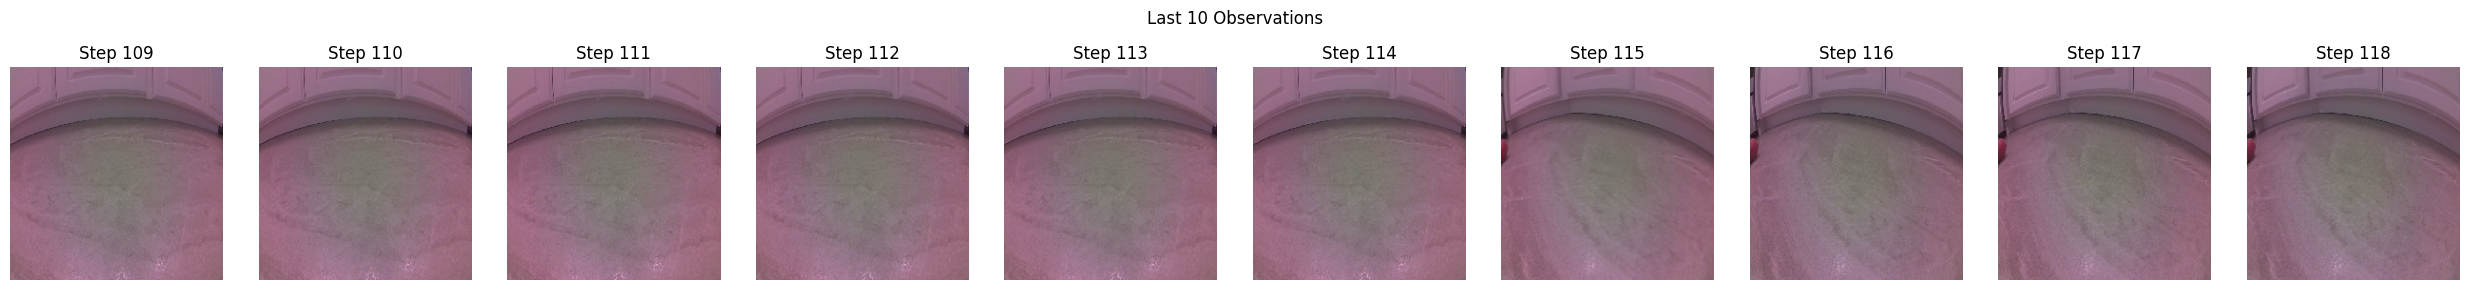

In [16]:
print("Starting Continuous MPC Control Loop...")
# --- Initialize Observation Buffers ---
# Use the globally determined NUM_PREV_FRAMES
observation_buffer = deque(maxlen=NUM_PREV_FRAMES + 1)
visualization_buffer = deque(maxlen=VISUALIZATION_BUFFER_SIZE) # For storing recent frames for display

print(f"Collecting {NUM_PREV_FRAMES + 1} initial observations...")
initial_obs_collected = 0
while initial_obs_collected < NUM_PREV_FRAMES + 1:
    obs = get_observation_real()
    if obs is not None:
        observation_buffer.append(obs) # Add tensor (C, H, W)
        visualization_buffer.append(obs.cpu().numpy()) # Add numpy version for vis
        initial_obs_collected += 1
        print(f"Collected initial observation {initial_obs_collected}/{NUM_PREV_FRAMES + 1}")
    else:
        print("Failed to get initial observation, retrying...")
        time.sleep(0.5)
    # Add a small delay to avoid overwhelming the server/network
    time.sleep(0.05) # Shorter delay between initial captures

if len(observation_buffer) != NUM_PREV_FRAMES + 1:
     print("Error: Could not collect enough initial observations. Exiting.")
     if 'remote_robot' in locals() and remote_robot:
         remote_robot.cleanup() # Use the cleanup method
     sys.exit(1) # Exit script
else:
     print("Initial observation buffer filled. Starting continuous control.")


# --- Main Control Loop ---
step_count = 0
start_run_time = time.time()
try:
    while True: # Run indefinitely until interrupted
        step_start_time = time.time()

        # Check RPyC connection before planning/acting
        if remote_robot is None or remote_robot.conn is None or remote_robot.conn.closed:
             logger.error("RPyC connection lost. Stopping control loop.")
             break

        step_count += 1
        print(f"\n--- Step {step_count} ---") # **ADDED PRINT STATEMENT**

        # 1. Plan the best action by comparing discrete options
        print("Planning action...") # **ADDED PRINT STATEMENT**
        plan_start_time = time.time()
        # Pass the current buffer (as a list) to the optimizer/chooser
        # **MODIFIED: Get predicted rewards back**
        action_val, predicted_rewards_tuple = choose_best_action(world_model, reward_model, list(observation_buffer))
        plan_duration = time.time() - plan_start_time
        print(f"Planning finished in {plan_duration:.3f}s") # **ADDED PRINT STATEMENT**

        # 2. Apply the chosen action (right motor only) via RPyC
        print(f"Applying action: {action_val:.1f}") # **ADDED PRINT STATEMENT**
        apply_action_real(action_val)

        # 3. Get the next observation via RPyC
        # print("Getting next observation...") # Optional print
        next_obs_tensor = get_observation_real()
        if next_obs_tensor is None:
            logger.warning("Failed to get observation after action. Continuing...")
            # Decide how to handle: continue, retry, or stop?
            # For now, we continue, but the observation buffer won't update correctly.
            # Consider adding a retry mechanism or stopping the loop.
            time.sleep(0.1) # Add a small delay if observation failed
            continue # Skip buffer update if obs failed
            # break # Option: Stop the loop on observation error
        else:
             # print("Observation received.") # Optional print
             # Add new observation to buffers if successful
             observation_buffer.append(next_obs_tensor)
             visualization_buffer.append(next_obs_tensor.cpu().numpy()) # Store numpy version

        step_duration = time.time() - step_start_time
        # Print step info periodically or based on verbosity setting
        # **MODIFIED: Print every step now for more detail**
        print(f"Step {step_count} Summary | Plan Time: {plan_duration:.3f}s | Step Time: {step_duration:.3f}s | Chosen Action: R={action_val:.1f} | Pred Rewards (0.0, 0.1): ({predicted_rewards_tuple[0]:.3f}, {predicted_rewards_tuple[1]:.3f})")

except KeyboardInterrupt:
    print("\nKeyboardInterrupt received. Stopping control loop.")
finally:
    # --- Cleanup ---
    print("Shutting down remote connection...")
    if 'remote_robot' in locals() and remote_robot:
        remote_robot.cleanup() # Use the cleanup method of RemoteJetBot
    print("Remote connection closed.")
    end_run_time = time.time()
    total_duration = end_run_time - start_run_time
    print(f"\n===== MPC Control Loop Finished =====")
    print(f"Ran for {step_count} steps.")
    if total_duration > 0:
        print(f"Total Duration: {time.strftime('%H:%M:%S', time.gmtime(total_duration))}")


# %% [markdown]
# ## Results Visualization (Optional - Shows last frames)

# %%
# Visualize observations using denormalized images from the visualization buffer
if visualization_buffer:
    print(f"\nVisualizing last {len(visualization_buffer)} captured observations...")
    vis_obs_np = np.array(visualization_buffer) # Shape: (num_steps, C, H, W)
    num_obs_to_show = min(len(vis_obs_np), 10) # Show up to 10 last frames

    fig, axes = plt.subplots(1, num_obs_to_show, figsize=(num_obs_to_show * 2.5, 3))
    if num_obs_to_show == 1: axes = [axes] # Make iterable if only one subplot

    # Get the indices for the last num_obs_to_show frames
    start_vis_index = len(vis_obs_np) - num_obs_to_show

    for i in range(num_obs_to_show):
        obs_index = start_vis_index + i
        obs_tensor = torch.from_numpy(vis_obs_np[obs_index]).float()
        obs_denorm = denormalize(obs_tensor)
        obs_img_display = obs_denorm.permute(1, 2, 0).cpu().numpy()
        obs_img_display = np.clip(obs_img_display, 0, 1)

        axes[i].imshow(obs_img_display)
        # Title relative to the end of the run
        axes[i].set_title(f"Step {step_count - num_obs_to_show + i + 1}")
        axes[i].axis('off')
    plt.suptitle(f"Last {num_obs_to_show} Observations")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("No observation data captured in the visualization buffer.")
